# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
! pip install einops
! git clone https://github.com/Gpoupart/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import gen_pointcloud, plot_triplets

fatal: destination path 'exam_2025' already exists and is not an empty directory.


## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


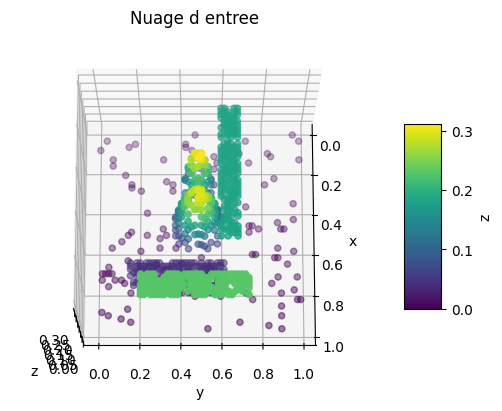

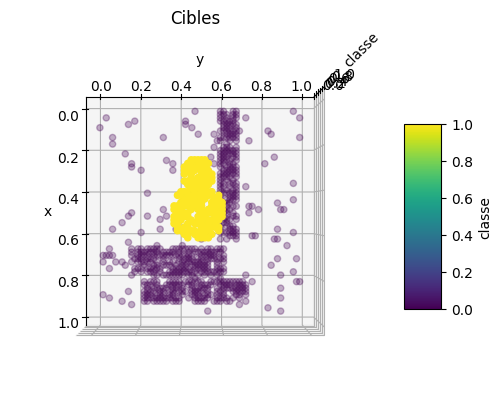

1


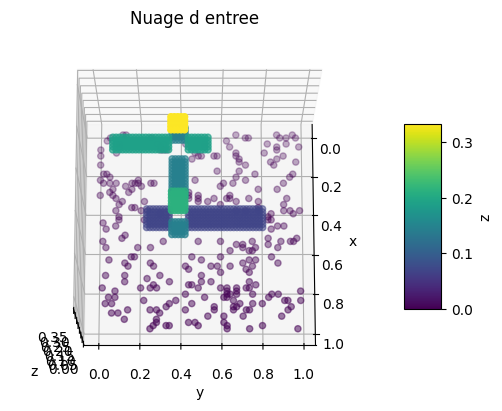

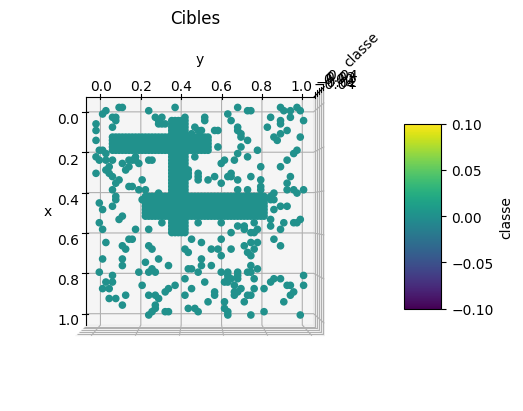

2


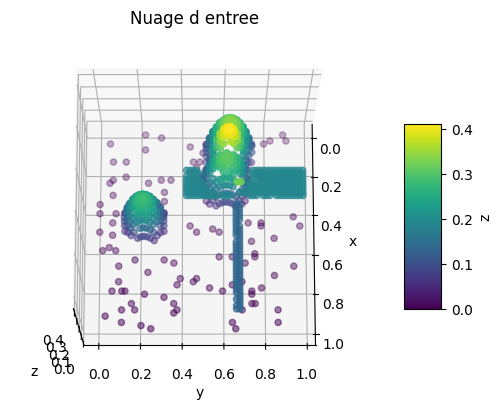

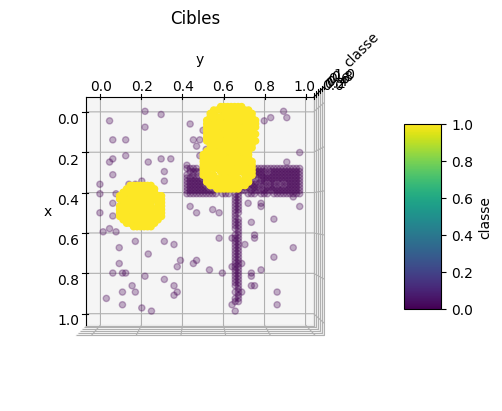

3


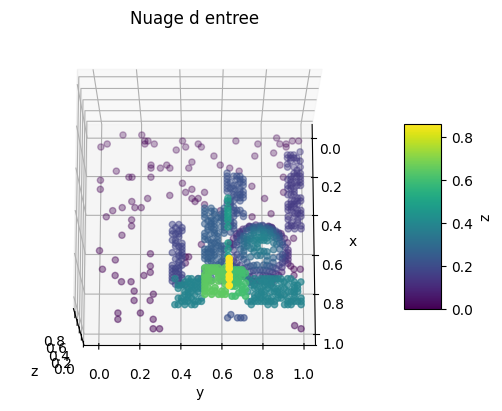

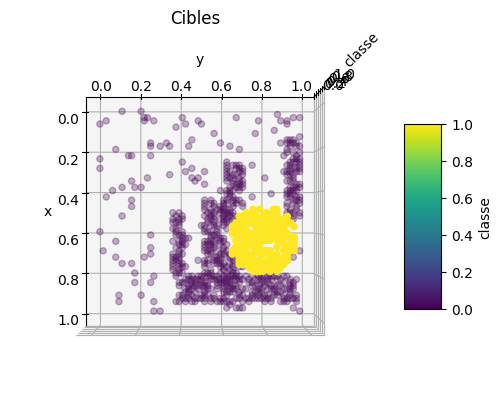

4


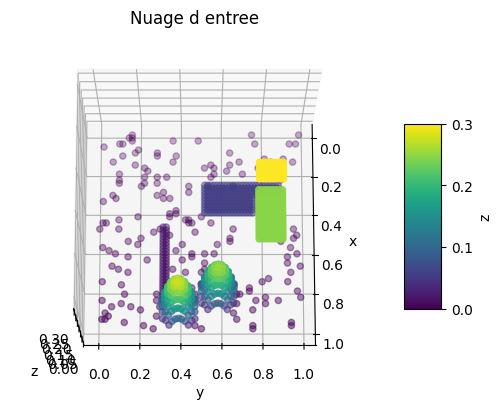

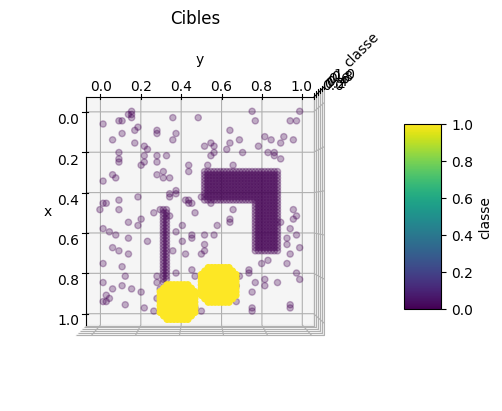

5


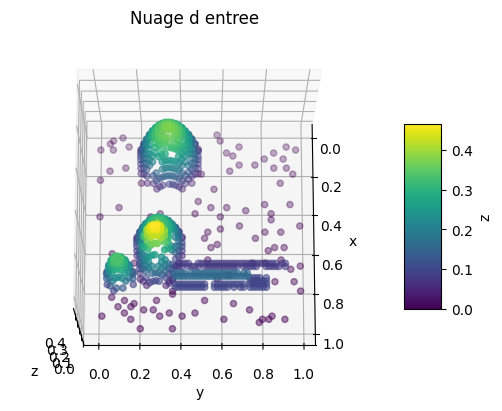

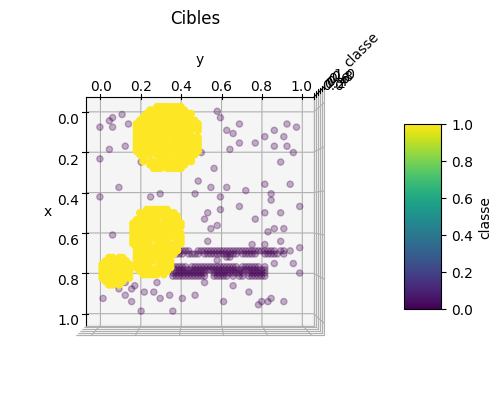

In [14]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation

**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

batch_size : le nombre d'exemples (ou de nuages de points) dans un batch.

N : le nombre de points dans chaque nuage de points (par exemple, le nombre de points échantillonnés sur les surfaces du terrain).

3 : chaque point du nuage de points est décrit par 3 coordonnées (x, y, z), représentant la position 3D de chaque point dans l'espace.

**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?

Les points ne sont pas ordonnés de manière particulière, c'est-à-dire qu'il n'y a pas de structure linéaire dans la représentation des points. Chaque point est simplement représenté par ses coordonnées (x, y, z) dans l'espace, sans priorité spécifique.

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

Les deux stratégies ont des fonctionnements différents :

FCN : Adaptation en voxelisation ou en projection 2D des points pour pouvoir utiliser des convolutions classiques, mais cela implique souvent une perte de précision.

ViT : Diviser le nuage de points en patches (tokens), et utiliser un Transformer pour traiter les relations complexes entre les points. Cela permet de traiter les nuages de points de manière flexible et d'exploiter le mécanisme d'attention pour capturer des dépendances spatiales complexes.


Bien que l'utilisation d'un FCN soit possible avec une représentation adéquate des points, l'approche avec un ViT semble plus prometteuse car elle peut mieux capturer les dépendances entre les points du nuage dans un espace 3D sans nécessiter de structure explicite en grille.

## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [15]:
from utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

Dans l'article introduisant PointNet, les auteurs expliquent que leur réseau est conçu pour respecter l'invariance par permutation des points d'entrée, ce qui signifie que l'ordre des points dans le nuage n'affecte pas la sortie.
Citation tirée de l'article :

"In this paper, we design a novel type of neural network that directly consumes point clouds, which well respects the permutation invariance of points in the input."

In [ ]:


# Génération des données pour un batch
batch_size = 6
input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()

# Initialisation du modèle PointNet
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

# Passage des points d'origine
output_original, _, _ = pointnet(input_points)

# Permute the points within each cloud, keeping the channel dimension unchanged
permuted_input_points = input_points[:, :, torch.randperm(input_points.size(2))]

# Passage des points permutés dans le modèle
output_permuted, _, _ = pointnet(permuted_input_points)

# Affichage des dimensions des sorties
print("Dimensions de la sortie originale :", output_original.size())
print("Dimensions de la sortie après permutation :", output_permuted.size())

# Comparaison des sorties en excluant la dimension du batch
# Nous voulons vérifier si les sorties sont identiques pour chaque échantillon du batch
are_outputs_identical = torch.allclose(output_original, output_permuted, atol=1e-6)
print("Les sorties sont-elles identiques ?", are_outputs_identical)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [16]:
optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))

# manually set alpha weights
alpha = np.array([0.2, 0.8])
gamma = 1
loss_fn = PointNetSegLoss(alpha=alpha, gamma=gamma, dice=True).cuda()

# exemple d'utilisation de PointNetSegLoss:
# La transposition permet de repasser la dimension relative
# aux probabilités en dernier, comme avec torch.nn.CrossEntropyLoss
proba_pred_list = outputs.transpose(1,2)
loss_fn(proba_pred_list, target_list)

NameError: name 'PointNetSegLoss' is not defined

In [ ]:
batch_size = 64
n_epochs = 200
n_batch_per_epoch = 10


for epoch in range(1, n_epochs):
  print('epoch : ', epoch)
  for batch in range(1,n_batch_per_epoch):
    ...

In [ ]:
input_points, target_list , target_points = gen_pointcloud(6)

# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet2.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()

# Accuracy:
...
# Tracé

for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  plot_triplets(...,
                title='Predictions',
                cbar_label='classe')
